In [11]:
import os
# Change to the directory of the current file
os.chdir(r"D:\MyDrive\10. MS in Data Science UofWisconsin\14. Final Project Maestria\Markowitz")

In [12]:

import numpy as np 
import pandas as pd 
from numbersAddTo1 import random_gen_weights
from unitCircle import unitCircle as unitCircleDf
import matplotlib.pyplot as plt
from function_filePrep import tickerList, download_data,missing_days_andIndexTimeZone, to_month_and_add_monthYear_columns
np.random.seed(1986)

n_rows = 10000
n_cols = 30
data = []
data_uniform= []

for _ in range(n_rows):
    row = random_gen_weights(n_cols)       
    data.append(row)
    data.append([1/30]*30)

#downloading only last year as I believe is more representative of the picture going forward
df_weights = pd.DataFrame(data)
df_ticker_price = download_data(list_stocks=tickerList,start_date = '2023-08-01', end_date = '2024-09-30')
df_ticker_price1=missing_days_andIndexTimeZone(df_ticker_price)
#os.chdir(os.path.dirname(os.path.abspath(__file__)))


#%%
## 41 rows of daily pct change in aug and sept 2024
training_1y_endJul2024=df_ticker_price1[:"2024-07-31"].copy()

training_pct_change=training_1y_endJul2024.pct_change().dropna()

The current working directory is: D:\MyDrive\10. MS in Data Science UofWisconsin\14. Final Project Maestria\Markowitz


[*********************100%***********************]  30 of 30 completed


In [13]:
port_means= []
port_sd = []
for row in df_weights.values: 
    iter=training_pct_change.dot(row)
    i_mean=iter.mean()
    i_sd = iter.std()
    port_means.append(i_mean*41) # times 41 to get expected return in 41 days (2 months)
    port_sd.append(i_sd * np.sqrt(41))
    
#%%
#renaming columns and adding sharpe ratio
df_weights.columns = training_pct_change.columns
df_weights['port_return'] = port_means
df_weights['port_risk'] = port_sd
df_weights['sharpe'] = df_weights['port_return']/df_weights['port_risk']

In [15]:
training_pct_change.head(3)

,AAPL,AMGN,AMZN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,...,MMM,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WMT
Date,,,,,,,,,,,,,,,,,,,,,
2023-08-02,-0.015490,-0.007367,-0.026426,-0.017094,-0.027856,-0.003742,-0.016810,-0.001519,-0.015835,-0.030664,...,-0.014924,0.003989,-0.026283,-0.017276,0.002176,-0.007022,0.000119,-0.009258,-0.003290,0.000691
2023-08-03,-0.007322,0.001259,0.005460,-0.002039,-0.000086,-0.021282,-0.022404,0.010841,-0.000376,-0.009386,...,-0.015793,0.000284,-0.002565,0.010511,0.002618,-0.009936,0.000119,0.005051,-0.007803,0.000251
2023-08-04,-0.048020,0.054530,0.082693,-0.006009,0.000000,-0.017801,-0.004500,-0.009784,-0.002255,0.009475,...,-0.015673,-0.006904,0.003429,0.001565,-0.010955,-0.004428,-0.004219,0.000963,-0.013309,-0.005777


In [16]:
def portfolio_return(weights, returns):
    return np.dot(weights, returns.mean()) * 252

def portfolio_risk(weights, returns):
    cov_matrix = returns.cov() * 252
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

def sharpe_ratio(weights, returns, risk_free_rate=0):
    port_return = portfolio_return(weights, returns)
    port_risk = portfolio_risk(weights, returns)
    return - (port_return - risk_free_rate) / port_risk

constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = [(0, 1) for _ in range(training_pct_change.shape[1])]


In [30]:
df_weights.sort_values('sharpe',ascending=False).loc[:,"AAPL":"WMT"].reset_index(drop=True).iloc[0,:].to_list()

[0.0,
 0.17,
 0.0,
 0.32,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.009999999999999898,
 0.08,
 0.0,
 0.01,
 0.0,
 0.0,
 0.0,
 0.16,
 0.01,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.24,
 0.0]

## Result from Minimize

In [51]:
#initial_guess = [1. / returns.shape[1]] * returns.shape[1]
initial_guess = df_weights.sort_values('sharpe',ascending=False).loc[:,"AAPL":"WMT"].reset_index(drop=True).iloc[0,:].to_list()
from scipy.optimize import minimize
result = minimize(sharpe_ratio, initial_guess, args=(training_pct_change,), method='SLSQP', bounds=bounds, constraints=constraints)

print("Optimized Weights:", result.x)
print("Maximized Sharpe Ratio:", -result.fun)


Optimized Weights: [1.43377246e-15 1.07268891e-01 7.54269144e-02 9.05605030e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.29417893e-15
 0.00000000e+00 0.00000000e+00 2.48048579e-16 2.62382370e-02
 0.00000000e+00 0.00000000e+00 9.69516326e-02 0.00000000e+00
 0.00000000e+00 1.22929622e-01 0.00000000e+00 0.00000000e+00
 3.61200125e-02 1.93426875e-15 5.42107779e-02 0.00000000e+00
 0.00000000e+00 3.28460436e-02 4.00229245e-02 6.95475937e-16
 1.12738190e-01 2.04686251e-01]
Maximized Sharpe Ratio: 3.1936266512914844


In [55]:
from copy import deepcopy
best1_weights= deepcopy( result.x)

In [69]:
init_guess=df_weights.sort_values('sharpe',ascending=False).loc[:,"AAPL":"WMT"].reset_index(drop=True).iloc[0,:]

In [75]:
init_guess=np.array( init_guess)

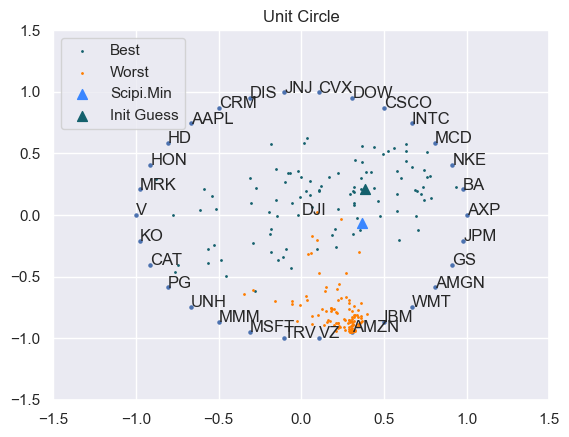

In [76]:

# PLOTTING UNICIRCLE

unitCircleDf['securities'] =\
df_weights.\
    sort_values('sharpe',ascending=False).reset_index(drop=True).\
    iloc[:1000,:].\
        loc[:,"AAPL":"WMT"].\
            rank(axis=1, method='max',ascending=False).\
            apply(lambda x: np.count_nonzero(x<=5),axis=0).sort_values().index


#%%
nbr_portfolios = 100

best1000portfolios = df_weights.\
    sort_values('sharpe',ascending=False).reset_index(drop=True).\
    iloc[:nbr_portfolios,:]

worst1000portfolios = df_weights.\
    sort_values('sharpe',ascending=True).reset_index(drop=True).\
    iloc[:nbr_portfolios,:]

bestPort_coord = pd.DataFrame(
    {
        'best_length': [np.array(x).dot(unitCircleDf.lengths) for x in best1000portfolios.loc[:,"AAPL":"WMT"].values],
        'best_height': [np.array(x).dot(unitCircleDf.heights) for x in best1000portfolios.loc[:,"AAPL":"WMT"].values]
    }
)

worstPort_coord = pd.DataFrame(
    {
        'worst_length': [np.array(x).dot(unitCircleDf.lengths) for x in worst1000portfolios.loc[:,"AAPL":"WMT"].values],
        'worst_height': [np.array(x).dot(unitCircleDf.heights) for x in worst1000portfolios.loc[:,"AAPL":"WMT"].values]
    }
)
#[value for value in best1_weights]
minimize_best1_coord =  pd.DataFrame(
    {
        'best_length': [best1_weights.dot(unitCircleDf.lengths)],
        'best_height': [best1_weights.dot(unitCircleDf.heights)]
    }
)

init_guess_coord =  pd.DataFrame(
    {
        'best_length': [init_guess.dot(unitCircleDf.lengths)],
        'best_height': [init_guess.dot(unitCircleDf.heights)]
    }
)

# plotting top n portfolios (blue), and bottom (1000) portfolios


plt.scatter(x=unitCircleDf.lengths, y=unitCircleDf.heights, s=5, color='b')
# Add labels
for i, txt in enumerate(unitCircleDf['securities']):
    plt.annotate(txt, (unitCircleDf['lengths'][i], unitCircleDf['heights'][i]))

plt.scatter(x=bestPort_coord.best_length, y=bestPort_coord.best_height, s=1, color='#15616d', label = 'Best')
plt.scatter(x=worstPort_coord.worst_length, y=worstPort_coord.worst_height, s=1, color='#ff7d00', label = 'Worst')
plt.scatter(x=minimize_best1_coord.best_length, y=minimize_best1_coord.best_height, s=50, color='#3a86ff', label = 'Scipi.Min',marker='^')
plt.scatter(x=init_guess_coord.best_length, y=init_guess_coord.best_height, s=50, color='#15616d', label = 'Init Guess',marker='^')
plt.annotate('DJI', (0, 0))
# Adding legend with bigger dots
plt.legend(markerscale=1)    



plt.xlim(-1.5, 1.5)
plt.ylim(-1.5,1.5)
plt.title('Unit Circle')
plt.show()
